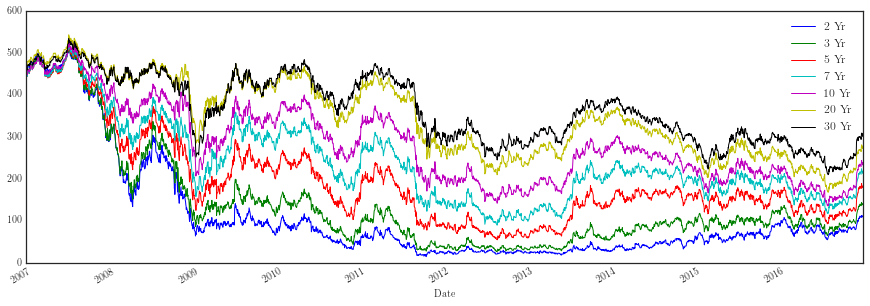

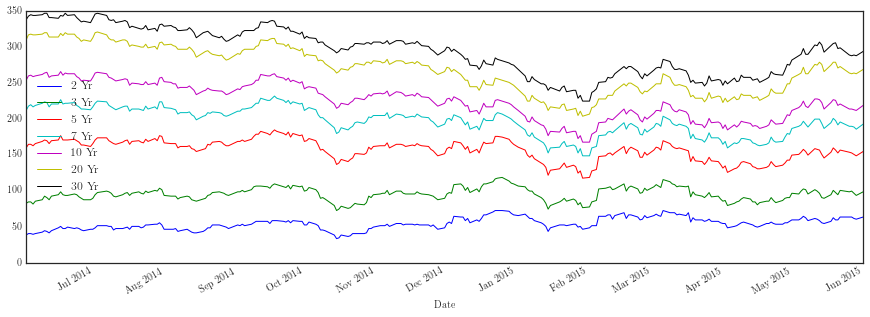

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import math
import datetime as dt
from matplotlib import cm, rc
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

from statsmodels.tsa.stattools import adfuller

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA, KernelPCA

#Load data, clean, re-index, remove 1mo, 6mo, 20y, save to pickle. 

df = pd.read_csv("USTYields.csv", sep=",")
df = df.drop(["1 Mo","3 Mo", "6 Mo", "1 Yr"], 1)
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)
df.set_index("Date", drop=True, inplace=True)
df.loc[:] *= 100 #convert to basis points

df.to_pickle("RawData")

#Save data from 10years ago to now
start_date = dt.datetime(2006, 12, 8)
end_date = df.index[-1]
data = df[start_date:end_date]
splitDates = np.array_split(data, 5)

with open('splitData', 'w') as f:
    pickle.dump(splitDates, f)

#choose last 2 years or so of data
start = dt.datetime(2014, 6, 1)
end = dt.datetime(2015, 6, 1)

raw = data[start:end]

data.plot(figsize=(15,5))
raw.plot(figsize=(15,5))


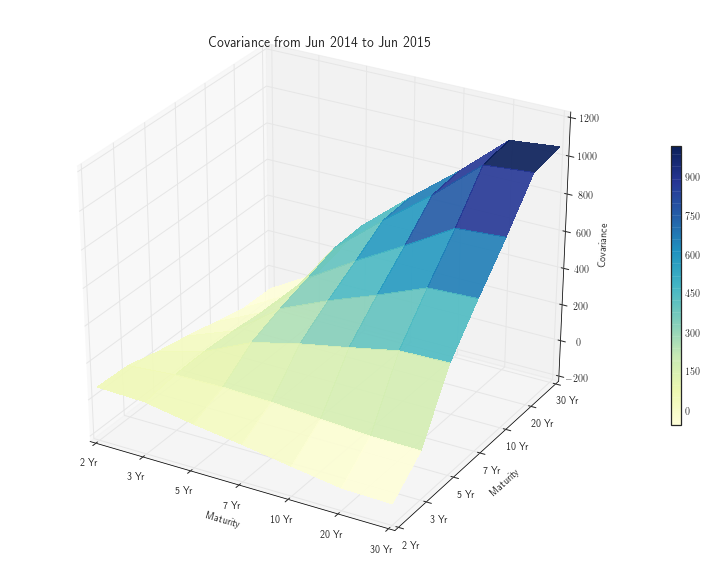

In [29]:
############ Covariance Chart ##############

meanVals = raw.mean()
demeaned = raw - meanVals
stDate, edDate = raw.index[0].strftime("%b %Y"), raw.index[-1].strftime("%b %Y")

#cov of data:
covM = raw.cov()
indexRef = covM.index
covM.index = range(len(covM))
covM.columns = covM.index

#generate X, Y, Z for cov plot:
X = covM.index
Y = covM.index
X, Y = np.meshgrid(X, Y)
zs = np.array([covM.iat[i, j] for i, j in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


#plot
plt.rcParams["font.family"] = "sans-serif"
fig = plt.figure(figsize=(14, 10), dpi=200)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,alpha=0.9, cmap=cm.YlGnBu,linewidth=0,antialiased=False)

ax.set_xticklabels(indexRef)
ax.set_yticklabels(indexRef)
ax.set_xlabel('Maturity')
ax.set_ylabel('Maturity')
ax.set_zlabel('Covariance')
fig.colorbar(surf, shrink=0.5, aspect=30)

plt.title("Covariance from %s to %s" % (stDate, edDate), fontsize=14)

plt.savefig("Covariance.png")

plt.show()



             PC1        PC2        PC3
2 Yr   -4.982143  49.695872 -64.793240
3 Yr    3.571701  59.300256 -15.729230
5 Yr   22.001456  47.258004  35.544534
7 Yr   33.565217  30.155041  31.488868
10 Yr  44.230757   6.404591  34.725395
20 Yr  55.891422 -18.774598 -35.033599
30 Yr  57.197224 -21.855208 -29.432269


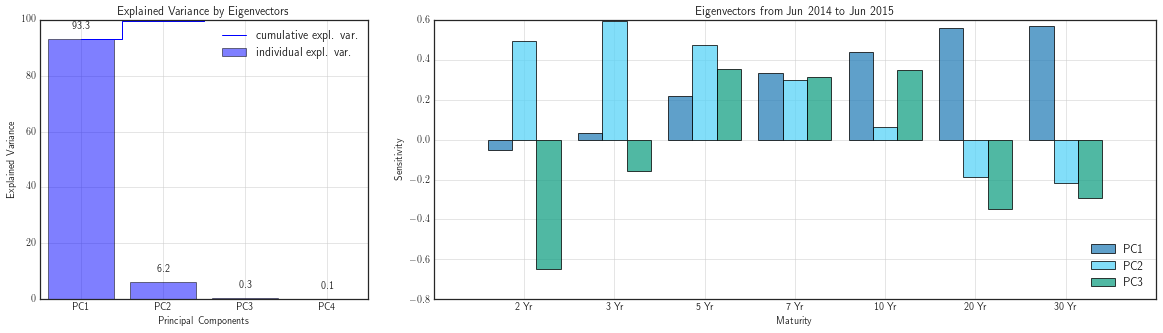

In [16]:
############ PCA ##############

# Eigenvalue decomp on Cov matrix:


evals, evecs = np.linalg.eig(covM)
epairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
epairs.sort(key=lambda x: x[0], reverse=True)

#normed evals
nevals = sorted([i*100/sum(evals) for i in evals])[::-1][:4]
cumExp = np.cumsum(nevals)
#print cumExp

#Eigenvector Dataframe
evTable = pd.DataFrame(index=indexRef)
for i in xrange(3):
    evTable.insert(i, "PC"+str(i+1), epairs[i][1])



#plot Expl. Variance
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(20, 5), dpi=400)
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax1.bar(range(4), nevals, alpha=0.5, align='center', label='individual expl. var.')
ax1.step(range(4), cumExp, where='mid', label='cumulative expl. var.')
ax1.set_xticks(range(4))
ax1.set_xticklabels(["PC1", "PC2", "PC3", "PC4"])
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance')
ax1.legend(loc="best")
ax1.set_title("Explained Variance by Eigenvectors", fontweight="bold")
ax1.grid()

rects = ax1.patches
labels = [str(round(i, 1))+" %" for i in nevals]

for rect,label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 3, label, ha='center', va='bottom')
    
    
    
#plot Eigenvectors
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
ax2.set_title("Eigenvectors from %s to %s"%(stDate, edDate), fontweight="bold")
ax2.grid()
bwidth = 0.27
adjpos = [-bwidth, 0, bwidth]
colors = ['#2980b9', '#58D3F7', '#16a085']
ind = np.arange(len(indexRef))
for col in xrange(len(evTable.columns)):
    ax2.bar(ind+adjpos[col], evTable.ix[:,col],alpha=0.75, width=bwidth,color=colors[col], align="center")
ax2.set_xlabel('Maturity')
ax2.set_ylabel('Sensitivity')
ax2.set_xticks(range(len(indexRef)))
ax2.set_xticklabels(indexRef)
ax2.legend(["PC1", "PC2", "PC3"], loc="lower right")
plt.savefig("Eigenvectors-Till Oct.png")

print evTable*100

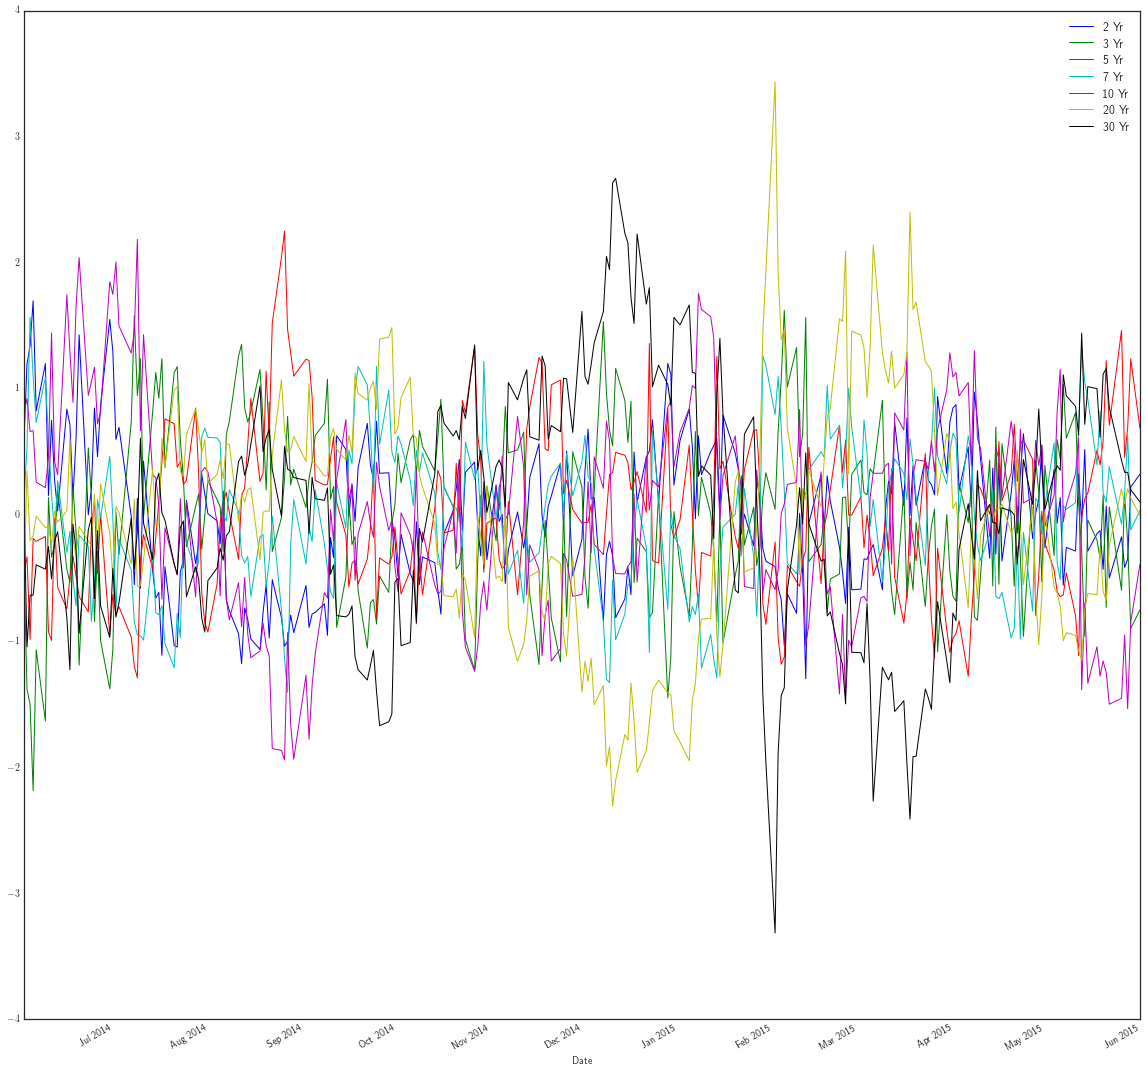

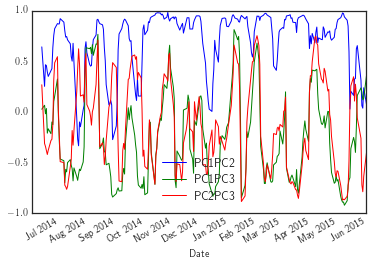

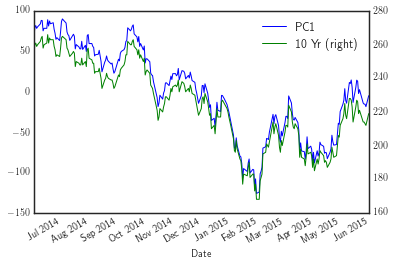

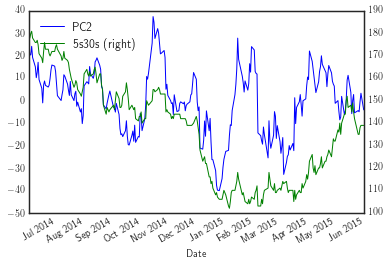

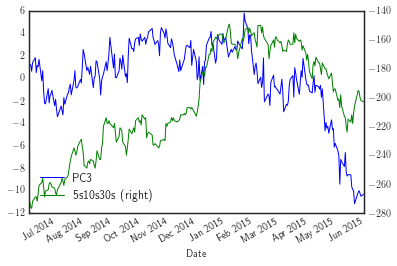

In [21]:
############ Reconstruct ##############


reconstr = demeaned.dot(evTable)
invEV = pd.DataFrame(np.linalg.pinv(evTable.values), evTable.columns, evTable.index)
rebuildRaw = reconstr.dot(invEV)
residuals = pd.DataFrame()
residuals = demeaned - rebuildRaw
residuals.plot(figsize=(20,20))

rollcorrs = pd.DataFrame()
rollcorrs["PC1PC2"] = reconstr["PC1"].rolling(window=10).corr(other=reconstr["PC2"])
rollcorrs["PC1PC3"] = reconstr["PC1"].rolling(window=10).corr(other=reconstr["PC3"])
rollcorrs["PC2PC3"] = reconstr["PC2"].rolling(window=10).corr(other=reconstr["PC3"])

rollcorrs.plot()

testpc1 = pd.DataFrame()
testpc1["PC1"] = reconstr["PC1"] 
testpc1["10 Yr"] = raw["10 Yr"]
testpc1.plot(secondary_y='10 Yr')
testpc2 = pd.DataFrame()
testpc2["PC2"] = -reconstr["PC2"] 
testpc2["5s30s"] = raw["30 Yr"]-raw["5 Yr"]
testpc2.plot(secondary_y='5s30s')
testpc3 = pd.DataFrame()
testpc3["PC3"] = reconstr["PC3"] 
testpc3["5s10s30s"] = raw["5 Yr"]*2-raw["10 Yr"]-raw["30 Yr"]

testpc3.plot(secondary_y='5s10s30s')


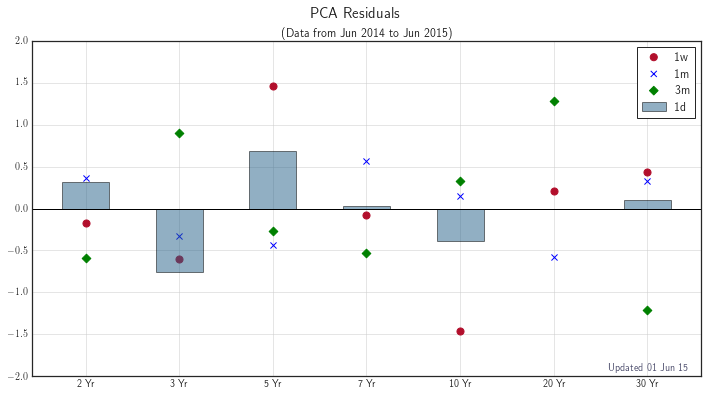

In [22]:
########### Residuals ############


## LEVEL
relVal = pd.DataFrame()
relVal = residuals.ix[[-1, -5, -20, -60]]
relVal.index = ["1d", "1w", "1m", "3m"]
relVal = relVal.transpose()
#relVal.plot(kind="bar")

## ZScore
relValz = pd.DataFrame()


fig = plt.figure(figsize=(12, 6), dpi=400)
ax = fig.add_subplot(111)
xvals = range(len(indexRef))
ax.bar(xvals, relVal["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax.set_xticks(xvals)
ax.set_xticklabels(indexRef)
plt.grid()
s = 25
ax.scatter(xvals, relVal["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax.scatter(xvals, relVal["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax.scatter(xvals, relVal["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax.axhline(0, color="black")

plt.suptitle("PCA Residuals", fontsize=15)
plt.title("(Data from %s to %s)"%(stDate, edDate))
ax.text(0.98, 0.01, 'Updated %s'%(raw.index[-1].strftime("%d %b %y")),
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='#4f506f', fontsize=10)
ax.legend(frameon=True, loc="best")

plt.savefig("pca residuals till oct")


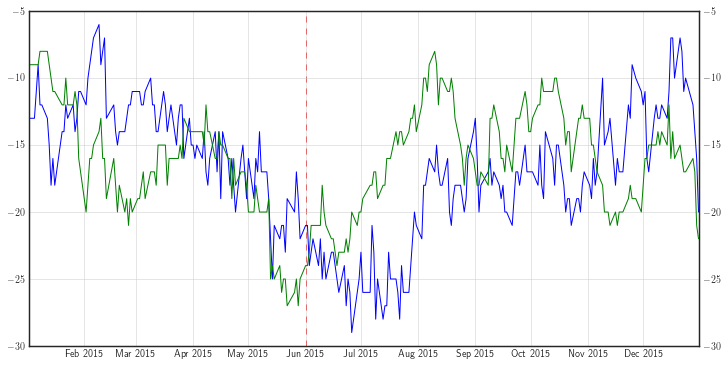

In [26]:
## PCA says to pay 2s3s5s , pay 7s10s20s


tradestart = dt.datetime(2015, 1, 1)
tradeend = dt.datetime(2016, 1, 1)

pxs = data[tradestart:tradeend]

trades = pd.DataFrame(index=pxs.index)
trades["7s10s20s"] = 2*pxs["10 Yr"]-pxs["7 Yr"]-pxs["20 Yr"]
trades["2s3s5s"] = 2*pxs["3 Yr"] - pxs["2 Yr"]- pxs["5 Yr"]

fig = plt.figure(figsize=(12, 6), dpi=400)
ax1 = fig.add_subplot(111)
ax1.grid()
ax1.plot(trades.index.values, trades["2s3s5s"], label="2s3s5s")
ax1.axvline(end, color='r', zorder=0, ls="dashed")

ax2 = ax1.twinx()
ax2.plot(trades.index.values, trades["7s10s20s"], color="g", label='7s10s20s')
